### CONTEXT

In this case study, we have developed Deep Learning model to detect and classify chest diesease to reduce the cost and time of detection. We have to develop a model from the chest X-ray data which has 4 classes - Healthy, Covid 19, Viral Pnuemonia, Bacterial Pnuemonia

### Import Libraries And Dataset

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Specify trainign data directory

X_ray_directory = 'F:\Data science\Datasets\Operations\Train'

In [4]:
# List the folders in the directory

os.listdir(X_ray_directory)

['0', '1', '2', '3']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% for cross validation

image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) nad validation is 104(20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size= 40, directory = X_ray_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset= 'training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size= 40, directory = X_ray_directory, shuffle= True, target_size= (256,256), class_mode= 'categorical', subset= 'validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels

train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]],

In [12]:
# Labels translate

label_name = { 0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### Visualize Dataset

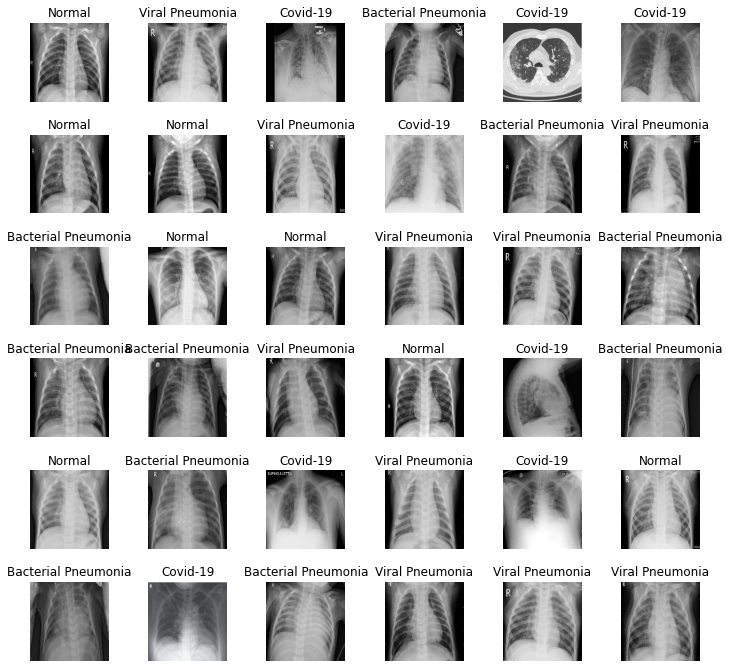

In [13]:
# Create a grid of 36 images with their corresponding labels

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize= (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_name[np.argmax(train_labels[i])])
    axes[i].axis('off')
    
plt.subplots_adjust(wspace= 0.5)

### Import Model with pretrained weights

In [14]:
basemodel = ResNet50(weights= 'imagenet', include_top = False, input_tensor= Input(shape= (256,256,3)))

In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
# Freezing the model upto the last stage.

for layer in basemodel.layers[:-10]:
    layers.trainable = False

### Build and Train Deep Learning Model

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


In [18]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(lr= 1e-4), metrics= ['accuracy'])

In [20]:
# Using early stoppin to exit training if validation loss is not decreasing after certain number of epochs (patience)

earlystopping = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20)

In [21]:
# Save the best model with lower validation loss

checkpointer = ModelCheckpoint(filepath= 'weights.hdf5', verbose= 1, save_best_only= True)

In [22]:
train_generator = image_generator.flow_from_directory(batch_size= 4, directory = X_ray_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset= 'training')
val_generator = image_generator.flow_from_directory(batch_size= 4, directory = X_ray_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset= 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [23]:
history = model.fit_generator(train_generator, epochs= 10, validation_data= val_generator, callbacks= [checkpointer, earlystopping])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.7056
Epoch 00001: val_loss improved from inf to 13.25671, saving model to weights.hdf5
107/107 [==============================] - 511s 5s/step - loss: 0.7748 - accuracy: 0.7056 - val_loss: 13.2567 - val_accuracy: 0.2500
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.8645
Epoch 00002: val_loss did not improve from 13.25671
107/107 [==============================] - 505s 5s/step - loss: 0.4246 - accuracy: 0.8645 - val_loss: 53.2471 - val_accuracy: 0.2500
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.9042
Epoch 00003: val_loss did not improve from 13.25671
107/107 [==============================] - 481s 4s/step - loss: 0.2800 - accuracy: 0.9042 - val_loss: 32.7624 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9252
Epoch 00004: val_loss did not i

### Evaluate Trained Deep Learning Model

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

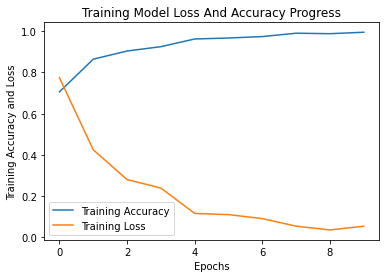

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')
plt.title('Training Model Loss And Accuracy Progress')
plt.legend(['Training Accuracy','Training Loss'])

Text(0, 0.5, 'Training Validation Loss')

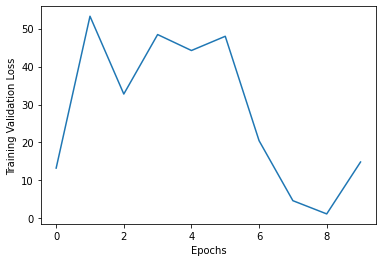

In [26]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Validation Loss')
plt.title('Training Model Validation Loss')

Text(0, 0.5, 'Training Validation Accuracy')

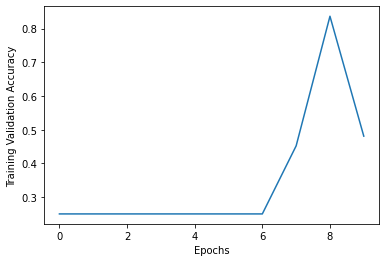

In [27]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Validation Accuracy')
plt.title('Training Model Validation Accuracy')

In [28]:
test_directory = 'F:\Data science\Datasets\Operations\Test'

In [29]:
test_gen = ImageDataGenerator(rescale= 1./255)

In [30]:
test_generator = test_gen.flow_from_directory(batch_size= 40, directory = test_directory, shuffle= True, target_size= (256,256), class_mode= 'categorical')

Found 40 images belonging to 4 classes.


In [31]:
evaluate = model.evaluate_generator(test_generator, steps= test_generator.n//4, verbose= 1 )
print('Accuracy Test : {}'.format(evaluate[1]))

10/10 [==============================] - 15s 468ms/step - loss: 21.6080 - accuracy: 0.4500
Accuracy Test : 0.44999998807907104


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [33]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [34]:
len(original)

40

In [35]:
score = accuracy_score(original,prediction)
print('Test Accuracy :', score)

Test Accuracy : 0.4


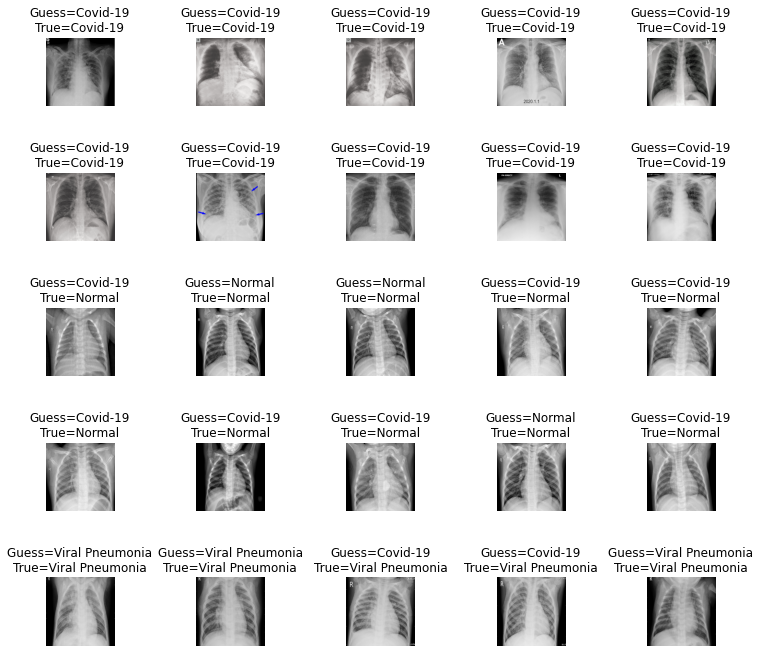

In [36]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_name[prediction[i]]), str(label_name[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [37]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.31      1.00      0.48        10
           1       0.60      0.30      0.40        10
           2       1.00      0.30      0.46        10
           3       0.00      0.00      0.00        10

    accuracy                           0.40        40
   macro avg       0.48      0.40      0.33        40
weighted avg       0.48      0.40      0.33        40



Text(0.5, 1.0, 'Confusion Matrix')

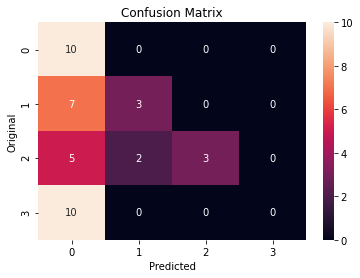

In [38]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))

ax = plt.subplot()

sns.heatmap(cm, annot= True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion Matrix')